### The code shows use of iterative workflow in the context of tweet generation for X

In [97]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import OllamaLLM
from typing import Annotated, TypedDict , Literal
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
import json

In [98]:
evaluater_llm = OllamaLLM(model ="llama3.2:latest")
generator_llm = OllamaLLM(model ="phi3:latest")
optimizer_llm = OllamaLLM(model ="phi4-mini:latest")

In [99]:
class tweetState(TypedDict):
    
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iterations: int  ## we use this as a limit because sometimes the model can get stuck in a loop



In [100]:
def generate_tweet(state: tweetState) -> tweetState:
    
    message = [
        SystemMessage("You are a funny and clever Twitter influencer"),
        HumanMessage(f"""Write a short, original tweet about {state['topic']}
    
        Rules:
        -Do not use question answer formate
        -Max  100 characters
        -Make it engaging and fun   
        """)
    ]

    response = generator_llm.invoke(message)

    return {state['tweet']: response}

In [101]:
class EvaluationSchema(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="The evaluation of the tweet")
    feedback: str = Field(description="Feedback on the tweet, if any")

In [102]:
##evaluation node function
parser = PydanticOutputParser(pydantic_object=tweetState)
def evaluate_tweet(state: tweetState) -> tweetState:
    
    message = [
        SystemMessage("You are a social media expert"),
        HumanMessage(f"""Evaluate the following tweet:  {state['tweet']}
        -Is it engaging? 
        -Does it follow the rules?
        -If it needs improvement, provide specific feedback
                     
                     """)
    ]

    structured_evaluation_llm = evaluater_llm.with_structured_output(
        output_parser=EvaluationSchema,)
    response = structured_evaluation_llm.invoke(message)

    return {state['evaluation']: response, 'feedback': response.feedback}

In [103]:
def optimizer_tweet(tweetState):
    message = [
        SystemMessage("You are a social media expert"),
        HumanMessage(f"""Optimize the following tweet: {tweetState['tweet']}
        -Make it more engaging
        -Follow the feedback: {tweetState['feedback']}
        """)
    ]

    response = optimizer_llm.invoke(message)

    return {tweetState['tweet']: response, 'iteration': tweetState['iteration'] + 1}

In [104]:
from typing import Literal

def conditional_edge(state: tweetState) -> Literal[END, "optimize"]:
    if state['evaluation'] == "approved" or state['iteration'] >= state['max_iterations']:
        return END
    else:
        return "optimize"



In [105]:
graph = StateGraph(tweetState)

graph.add_node("generate", generate_tweet)
graph.add_node("evaluate",evaluate_tweet)
graph.add_node("optimize", optimizer_tweet)

graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")
graph.add_conditional_edges("evaluate", conditional_edge)
graph.add_edge("optimize", "evaluate")

In [106]:
workflow = graph.compile()

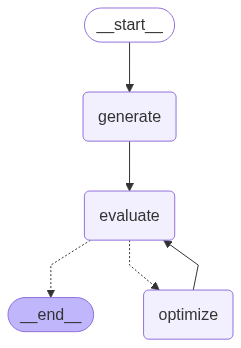

In [107]:
workflow